## Homework №2

### Neural machine translation and Attention layer.

Your ultimate tast is to enchance the Day4 architecture for Neural Machine Translation task from German to English.
It consists of two parts.
__After you finish some experiments__, please, write down some notes highlighting your main ideas you've got/problems you've faced/solutions you've found during the experiments. 

##### Part 1. Attention implementation.
Your first task is to implement the attention layer, modify the Decoder and test your new seq2seq model for machine translation. Code in this notebook refers a lot to the Day04 practical class. You have to modify the network from the class by adding `Attention` module to it.

_Optional: if you wish, you could also try the bidirectional LSTM in the Encoder._

##### Part 2. CNN encoder implementation.
The second task is to redesign the `Encoder` to use CNN instead of LSTM. `Attention` is not required in this part.



You may leave all the data loading, data preprocessing parts the same as it was in Day4 practice.

###  Part 1. Attention

Attention layer can take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

You can use any type of the attention scores you prefer. We have met at least three of them:

<img src="scoring_functions.png" />


_Some additional notes coming next:_

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of this as calculating a weighted sum of the "match" over all `dec_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](assets/seq2seq9.png)

In [ ]:
! pip install torchtext

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
! python -m spacy download en
! python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 11.1MB 652kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.1.0-cp36-none-any.whl size=11073066 sha256=dda094138c82976d9d5bdc980f2ea82856c7cea5d839bd377665cb966cc6b78f
  Stored in directory: /tmp/pip-ephem-wheel-cache-d1m97ibo/wheels/b4/8b/5e/d2ce5d2756ca95de22f50f68299708009a4aafda2aea79c4e4
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [ ]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:03<00:00, 314kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 91.4kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 87.3kB/s]


In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [ ]:
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear(enc_hid_dim+dec_hid_dim, 1)
        
    def forward(self, hidden, encoder_outputs):
        comb = torch.cat((hidden, encoder_outputs), 2)
        out = self.attn(comb)
        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)
        
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(p=dropout) 
    def forward(self, src):


        embedded = self.dropout(self.embedding(src))
        

        output, (hidden, cell) = self.rnn(embedded)

        
        return hidden, cell

### Decoder

To make it really work you should also change the`Decoder` class from the classwork in order to make it to use `Attention`. 
You may just copy-paste `Decoder` class and add several lines of code to it.

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word (that has been embedded), $y_t$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(y_t, w_t, s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](assets/seq2seq10.png)

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.attn = Attention(hid_dim, hid_dim)
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(num_embeddings=output_dim, embedding_dim=emb_dim)
        
        self.rnn = nn.LSTM(input_size=emb_dim+hid_dim, hidden_size=hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.out = nn.Linear(in_features=hid_dim, out_features=output_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, hidden, cell):

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

   
        weights = self.attn(hidden, cell)
        
        nw = F.softmax(weights)
        a, b, c = nw.shape
        nw = nw.view(b, c, a)

        a, b, c = cell.shape
        cell = cell.view(b, a, c)
      
        attn_out = torch.bmm(nw, cell)
        
        a, b, c = attn_out.shape
        attn_out = attn_out.view(b, a, c)
        attn_out = attn_out.type(torch.cuda.FloatTensor)
        
        input_lstm = torch.cat((attn_out, embedded), 2)
        
        a, b, c = cell.shape
        cell = cell.view(b, a, c)
        
        output, (hidden, cell) = self.rnn(input_lstm)
    
        output = self.out(output)

        return output, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)

        input = trg[0,:]
        
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = trg[t]
        
        return outputs

Here should go Seq2Seq training pipeline (reuse code from Day 4).

Compare the results. Write down some thoughts about translation quality. Was attention worth adding to the model?

In [ ]:
INPUT_DIM = len(SRC.vocab)
BIDIRECTIONAL = True
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
next(model.named_parameters())

('encoder.embedding.weight', Parameter containing:
 tensor([[-0.1117, -0.4966,  0.1631,  ..., -0.1973,  0.8522, -0.4066],
         [-1.4113,  0.0200, -0.4115,  ...,  0.9230, -0.6661, -0.6180],
         [ 1.3107,  1.4736, -0.2851,  ...,  0.8378, -0.3407,  0.2583],
         ...,
         [-1.1335, -0.1591, -2.5088,  ...,  0.8838, -0.5083,  0.1757],
         [-1.2402, -0.0048,  1.2349,  ...,  0.7528, -0.2642, -1.2838],
         [-0.7190, -1.0462,  1.1170,  ..., -0.6319, -0.8136, -0.9662]],
        device='cuda:0', requires_grad=True))

In [ ]:
def init_weights(m):
  for name, param in m.named_parameters():
    nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (attn): Attention(
      (attn): Linear(in_features=512, out_features=1, bias=True)
    )
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(512, 256, num_layers=2, dropout=0.5)
    (out): Linear(in_features=256, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,401,990 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        

        
        loss = criterion(output, trg)
        
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0)
            output = output[1:].view(-1, output.shape[-1])
            
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

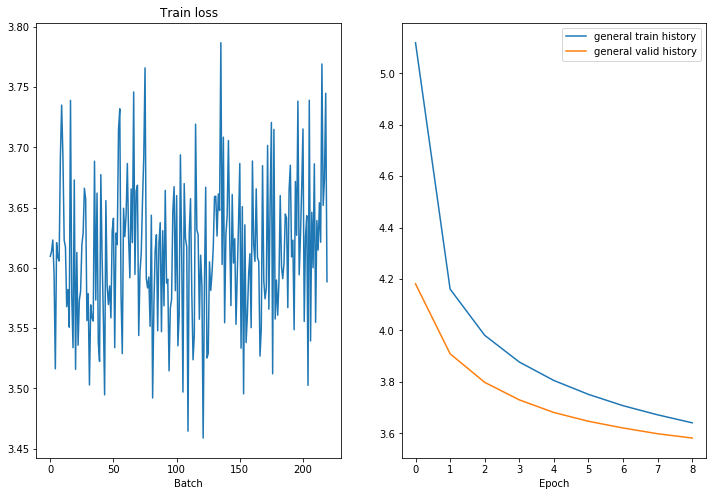

Epoch: 10 | Time: 1m 8s
	Train Loss: 3.614 | Train PPL:  37.119
	 Val. Loss: 3.568 |  Val. PPL:  35.430


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/'My Drive'

 0321992784CPP2.epub
 142011.JPG
'2014 UG Students Orientation & Registration.docx'
 Alizhan.Akhmetkaliyev_IndividualW.pptx
 Alizhan_Akhmetkaliyev_Profile.docx
 Alizhan_Akhmetkaliyev_Profile.gdoc
 capstone-I-report.pdf
 caqGoY6yRP0.jpg
'chinese summer camp 2014_application form (1).gsheet'
'chinese summer camp 2014_application form.gsheet'
'Colab Notebooks'
 FinalProject.rar
 IEEE.png
 InsureTech_Pres
'Lab2EMD (1).docx.gdoc'
 Lab6_1.cpp
 Lab6_2.cpp
 lstm.pt
'Monson H -Solution Manual of Statistical Digital Signal Processing Modeling.pdf'
 PAC-ALIZHAN.gslides
'Personal Data Form (1).gdoc'
'Personal Data Form.doc'
'Personal Data Form.gdoc'
 pres.gslides
'ProjectF (1).mp4'
'ProjectF - Alizhan Akhmetkaliyev.mp4'
 ProjectF.mp4
'Reviewer Comment.pdf'
 rnn.pt
'Test 6 ( Longman).rar'
'Test 8.rar'
'Unified Real Time Object Detection.gslides'
'Untitled document (1).gdoc'
'Untitled document.gdoc'
 Videos
'Warcraft lll'
'Warcraft lll.rar'
'Where is Waldo?.gslides'
'Winter break check-out form.html

In [ ]:
att_save_name = 'att.pt'
path_att = F"/content/gdrive/My Drive/{att_save_name}"
torch.save(model.state_dict(), path_att)

In [ ]:
model.load_state_dict(torch.load(path_att))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


| Test Loss: 3.581 | Test PPL:  35.904 |


### Part 2. CNN encoder.
Now try to modify the `Encoder class` and tune the network again. Try to achieve the score at least comparable to the original translation model without attention layer.

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.conv = nn.Sequential(
            nn.Conv1d(emb_dim, hid_dim, kernel_size = 3, stride = 1),
            nn.AdaptiveAvgPool1d(1),
            Flatten()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU()
        )

    def forward(self, input):
      
        embedded = self.embedding(input)
        a, b, c = embedded.shape
        embedded = embedded.view(b, c, a)

        out = self.conv(embedded)
        out = self.fc(out)
        out = out[None, :, :]
        return out

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        
        self.out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_data, hidden):
        
        input_data = input_data.unsqueeze(0)
        
        embedded = self.dropout(self.embedding(input_data))

        output, hidden = self.rnn(embedded, hidden)

        prediction = self.out(output.squeeze(0))

        
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        hidden = self.encoder(src)

        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = trg[t]
        
        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = CNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
model.apply(init_weights)

Seq2Seq(
  (encoder): CNNEncoder(
    (embedding): Embedding(7855, 256)
    (conv): Sequential(
      (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
      (1): AdaptiveAvgPool1d(output_size=1)
      (2): Flatten()
    )
    (fc): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(256, 512, dropout=0.5)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

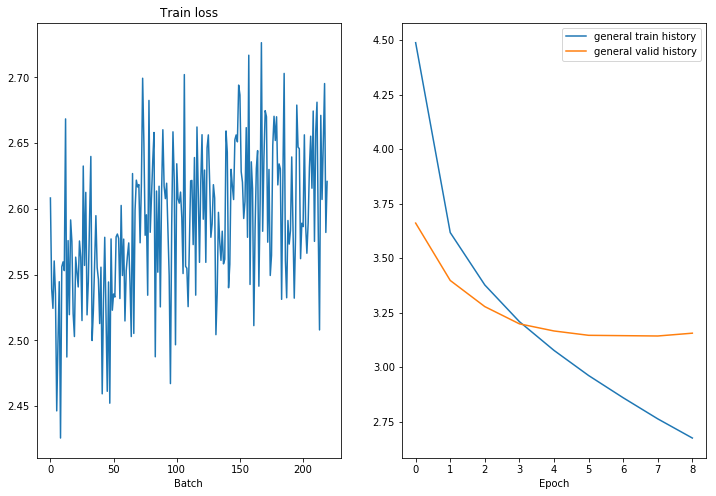

Epoch: 10 | Time: 1m 2s
	Train Loss: 2.590 | Train PPL:  13.330
	 Val. Loss: 3.164 |  Val. PPL:  23.659


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
cnn_save_name = 'cnn.pt'
path_cnn = F"/content/gdrive/My Drive/{cnn_save_name}"
torch.save(model.state_dict(), path_cnn)

In [ ]:
model.load_state_dict(torch.load(path_cnn))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.158 | Test PPL:  23.527 |
